# <u>***ANOMALY DETECTION : CREDIT CARD FRAUD***</u>

**Problem: Anomaly Detection in Credit Card Transactions**

# Table of Contents

**[1. SUMMARY](#1.-SUMMARY)**

**[2. DATA](#2.-DATA)**

> [2.1 About the Features](#2.1-About-the-Features)

> [2.2 Problem](#2.2-Problem )

> [2.3 Target Variable](#2.3-Target-Variable)

**[3. ANALYSIS](#3.-ANALYSIS)**

> [3.1 Reading the Data](#3.1-Reading-the-Data)

> [3.2 Exploratory Data Analysis (EDA) & Visualization](#3.2-Exploratory-Data-Analysis-(EDA)-&-Visualization)

>> [3.2.1 The Examination of Target Variable](#3.2.1-The-Examination-of-Target-Variable)

>> [3.2.2 The Examination of Numerical Features](#3.2.2-The-Examination-of-Numerical-Features)

**[4. FEATURE SCALING](#4.-FEATURE-SCALING)**

**[5. MODELLING & MODEL PERFORMANCE](#5.-MODELLING-&-MODEL-PERFORMANCE)**

> [5.1 The Implementation of Isolation Forest](#5.1-The-Implementation-of-Isolation-Forest)

> [5.2 The Implementation of One-Class SVM](#5.2-The-Implementation-of-One-Class-SVM)

> [5.3 The Implementation of Autoencoders](#5.3-The-Implementation-of-Autoencoders)

> [5.4 The Implementation of Local Outlier Factor (LOF)](#5.4-The-Implementation-of-Local-Outlier-Factor-(LOF))

> [5.5 The Implementation of DBSCAN](#5.5-The-Implementation-of-DBSCAN)

**[6. THE COMPARISON OF MODELS](#6.-THE-COMPARISON-OF-MODELS)**

**[7. CONCLUSION](#7.-CONCLUSION)**

**[8. REFERENCES](#8.-REFERENCES)**

> [Note](#Note)

# 1. SUMMARY 

I employed Exploratory Data Analysis (EDA) and various Anomaly Detection Algorithms, including Isolation Forest, One-Class SVM,  Autoencoders, Local Outlier Factor (LOF) and DBSCAN to examine the dataset 'Credit Card Fraud Detection' from the Kaggle website, which is labeled as 'creditcard.csv'. 

(https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud )

I attempted to explore the dataset comprehensively, examining various aspects and visualizing as much as possible to gain insights into the data. I employed ---five(5)--  Anomaly Detection Algorithms.

In [3]:
# installing the necessary libraries

!pip install tensorflow
!pip install plotly
!pip install plotly cufflinks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout  
from tensorflow.keras.regularizers import l2 

import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import iplot
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)
cf.go_offline()

palette = ['#00777F', '#5BABF5', '#AADEFE', '#EAAC9F', '#8AA0AF']
sns.set_theme(context='notebook', palette=palette, style='darkgrid')

# Suppress the FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Function for determining the number and percentages of missing values

def missing (df):
    num_of_missing = df.isnull().sum().sort_values(ascending=False)
    percentage_of_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([num_of_missing, percentage_of_missing], axis=1, keys=['Num_of_missing', 'Percentage_of_missing'])
    return missing_values

In [5]:
# Function for insighting summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

# 2. DATA

## 2.1 About the Features

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

* It contains only numerical input variables which are the result of a PCA transformation.
* Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## 2.2 Problem

This is an anomaly detection problem where I will make predictions on the target variable "Class". Subsequently, I will compare the predictions of five machine learning algorithms and attempt to determine the best-performing model.

## 2.3 Target Variable

In a fraud detection problem where the target variable is Class (indicating whether a transaction is fraudulent or not), the challenge is to identify fraud (anomalies) among a majority of normal transactions. When applying different anomaly detection algorithms such as Isolation Forest, One-Class SVM, Autoencoders, Local Outlier Factor (LOF), and DBSCAN, the target variable is not explicitly used during model training (since these are generally unsupervised learning methods). Instead, these algorithms learn from the structure of the data to detect outliers, which can later be compared with the target variable to evaluate performance.

Fraudulent transactions (the target variable "Class" with value 1) are identified as anomalies or outliers by each of these algorithms. The common theme across these methods is that fraud is treated as data that deviates significantly from the majority of transactions (which are normal).
The target variable is found by comparing the algorithm's prediction of whether a transaction is normal or anomalous with the actual labels, allowing we to measure the model's effectiveness at detecting fraud.

# 3. ANALYSIS

## 3.1 Reading the Data

In [12]:
df = pd.read_csv('creditcard.csv')

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3.2 Exploratory Data Analysis (EDA) & Visualization

In [15]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [16]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
df.tail(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284797,172782.0,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49,0
284798,172782.0,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,24.05,0
284799,172783.0,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,79.99,0
284800,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
284801,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [18]:
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
46003,42600.0,-1.038573,0.581351,2.130412,0.302775,-0.941211,-0.266985,-0.328104,0.638420,0.210657,...,0.047430,0.017667,-0.064241,0.404782,-0.133413,0.298141,-0.039629,0.020557,28.75,0
150872,94079.0,-0.326985,0.568130,-0.489545,0.594490,2.144198,-1.770021,1.399729,-0.786819,0.785114,...,0.163845,0.855353,-0.162670,-0.167118,-0.631072,-0.701993,-0.106280,0.122819,1.50,0
20519,31096.0,-0.343889,-0.171795,0.108610,-2.018750,2.023101,3.656570,-0.394026,0.967278,-1.018891,...,-0.396021,-0.677424,-0.095961,1.000173,-0.154617,0.205369,0.127106,0.141121,11.50,0
30530,35968.0,1.071733,-0.222346,1.003212,1.503936,-0.785765,0.428808,-0.640736,0.433246,0.935233,...,-0.049344,0.100576,-0.026221,0.186019,0.483371,-0.279524,0.056265,0.008569,2.00,0
197456,132024.0,-3.886210,-4.583302,-0.574025,0.587081,-1.798765,0.069109,2.344452,0.362751,-0.139207,...,1.181585,0.658498,2.215263,-0.031007,0.578653,-0.636434,-0.393711,-0.371763,1050.20,0
88196,62027.0,0.696500,-1.562852,0.782349,0.651842,-1.617552,0.353357,-0.771709,0.201522,-0.377060,...,-0.043184,-0.227136,-0.306929,-0.030667,0.272196,-0.281232,0.028552,0.075661,298.40,0
240307,150545.0,0.259210,0.881618,-0.751865,-0.243200,1.106177,-1.051112,0.963047,-0.269313,-0.049892,...,0.268545,0.875115,-0.259603,-0.730101,-0.294142,-0.115765,0.139360,0.126753,10.95,0
11049,19065.0,-0.746178,0.589813,2.548952,-1.678379,-0.495494,-0.671473,0.279905,-0.064648,2.313490,...,-0.098883,0.123447,-0.339169,0.356384,0.513308,-0.816157,0.084538,0.072272,11.85,0
63466,50729.0,-0.683502,0.444521,2.298155,1.336718,0.012177,2.612271,-0.459235,0.884856,-0.090692,...,0.220090,0.936358,0.008569,-1.001654,-0.670696,-0.100357,0.155562,0.125574,42.00,0
228672,145604.0,-4.884376,-3.789236,-0.535805,1.579628,2.948847,-3.065771,-1.120778,0.121460,-0.257489,...,0.155700,0.129430,-2.230083,0.124456,0.456016,0.174602,0.779968,-1.385424,143.76,0


In [19]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [20]:
print("My dataset consists of ", df.shape[0], "rows and", df.shape[1], "columns")

My dataset consists of  284807 rows and 31 columns


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [23]:
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [24]:
# to find how many unique values object features have

for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

Time has 124592 unique value
V1 has 275663 unique value
V2 has 275663 unique value
V3 has 275663 unique value
V4 has 275663 unique value
V5 has 275663 unique value
V6 has 275663 unique value
V7 has 275663 unique value
V8 has 275663 unique value
V9 has 275663 unique value
V10 has 275663 unique value
V11 has 275663 unique value
V12 has 275663 unique value
V13 has 275663 unique value
V14 has 275663 unique value
V15 has 275663 unique value
V16 has 275663 unique value
V17 has 275663 unique value
V18 has 275663 unique value
V19 has 275663 unique value
V20 has 275663 unique value
V21 has 275663 unique value
V22 has 275663 unique value
V23 has 275663 unique value
V24 has 275663 unique value
V25 has 275663 unique value
V26 has 275663 unique value
V27 has 275663 unique value
V28 has 275663 unique value
Amount has 32767 unique value
Class has 2 unique value


In [25]:
missing (df)

,Num_of_missing,Percentage_of_missing
Time,0,0.0
V16,0,0.0
Amount,0,0.0
V28,0,0.0
V27,0,0.0
V26,0,0.0
V25,0,0.0
V24,0,0.0
V23,0,0.0
V22,0,0.0


### 3.2.1 The Examination of Target Variable

In [27]:
first_looking("Class")

column name    :  Class
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Class
0    284315
1       492
Name: count, dtype: int64


Class
0    284315
1       492
Name: count, dtype: int64


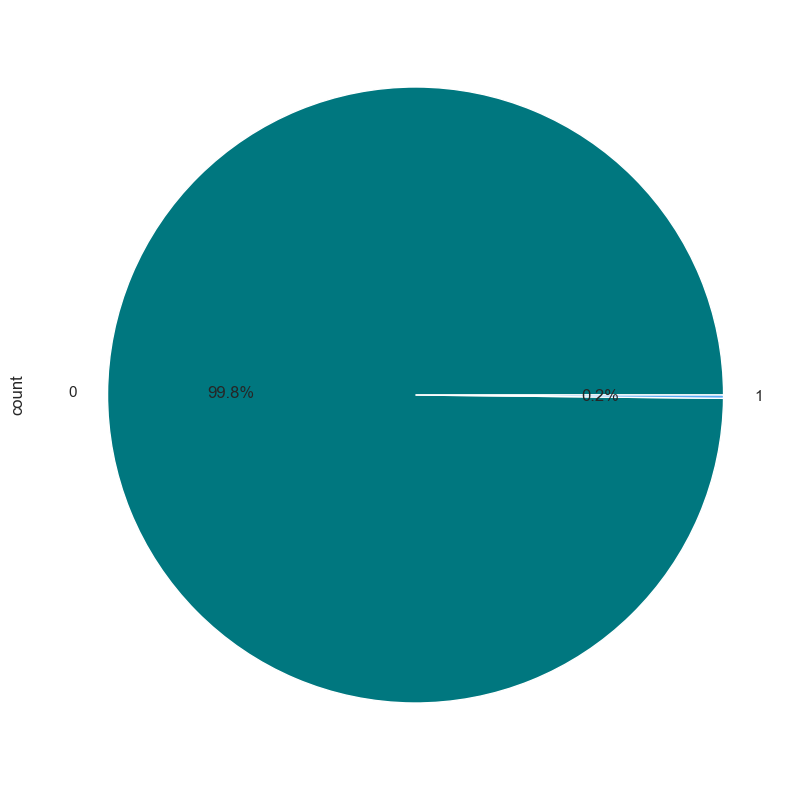

In [28]:
print(df["Class"].value_counts())
df["Class"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(10,10));

In [29]:
# discovering the numbers and percentages of frauded and NOT frauded customers

y = df['Class']
print(f'Percentage of Frauded Customer: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} cases for Frauded Customer)\nPercentage of NOT Frauded Customer: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} cases for NOT Frauded Customer)')

Percentage of Frauded Customer: % 0.17 --> (492 cases for Frauded Customer)
Percentage of NOT Frauded Customer: % 99.83 --> (284315 cases for NOT Frauded Customer)


In [30]:
# discovering the statistical values over other variables of NOT frauded customers 

df[df['Class']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Time,284315.000000,94838.202258,47484.015786,0.000000,54230.000000,84711.000000,139333.000000,172792.000000
V1,284315.000000,0.008258,1.929814,-56.407510,-0.917544,0.020023,1.316218,2.454930
V2,284315.000000,-0.006271,1.636146,-72.715728,-0.599473,0.064070,0.800446,18.902453
V3,284315.000000,0.012171,1.459429,-48.325589,-0.884541,0.182158,1.028372,9.382558
V4,284315.000000,-0.007860,1.399333,-5.683171,-0.850077,-0.022405,0.737624,16.875344
V5,284315.000000,0.005453,1.356952,-113.743307,-0.689398,-0.053457,0.612181,34.801666
V6,284315.000000,0.002419,1.329913,-26.160506,-0.766847,-0.273123,0.399619,73.301626
V7,284315.000000,0.009637,1.178812,-31.764946,-0.551442,0.041138,0.571019,120.589494
V8,284315.000000,-0.000987,1.161283,-73.216718,-0.208633,0.022041,0.326200,18.709255
V9,284315.000000,0.004467,1.089372,-6.290730,-0.640412,-0.049964,0.598230,15.594995


In [31]:
# discovering the statistical values over other variables of frauded customers 

df[df['Class']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Time,492.000000,80746.806911,47835.365138,406.000000,41241.500000,75568.500000,128483.000000,170348.000000
V1,492.000000,-4.771948,6.783687,-30.552380,-6.036063,-2.342497,-0.419200,2.132386
V2,492.000000,3.623778,4.291216,-8.402154,1.188226,2.717869,4.971257,22.057729
V3,492.000000,-7.033281,7.110937,-31.103685,-8.643489,-5.075257,-2.276185,2.250210
V4,492.000000,4.542029,2.873318,-1.313275,2.373050,4.177147,6.348729,12.114672
V5,492.000000,-3.151225,5.372468,-22.105532,-4.792835,-1.522962,0.214562,11.095089
V6,492.000000,-1.397737,1.858124,-6.406267,-2.501511,-1.424616,-0.413216,6.474115
V7,492.000000,-5.568731,7.206773,-43.557242,-7.965295,-3.034402,-0.945954,5.802537
V8,492.000000,0.570636,6.797831,-41.044261,-0.195336,0.621508,1.764879,20.007208
V9,492.000000,-2.581123,2.500896,-13.434066,-3.872383,-2.208768,-0.787850,3.353525


In [32]:
# Spliting Dataset into numeric & categoric features

numerical= df.drop(['Class'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


Categorical Columns: Index([], dtype='object')


### 3.2.2 The Examination of Numerical Features

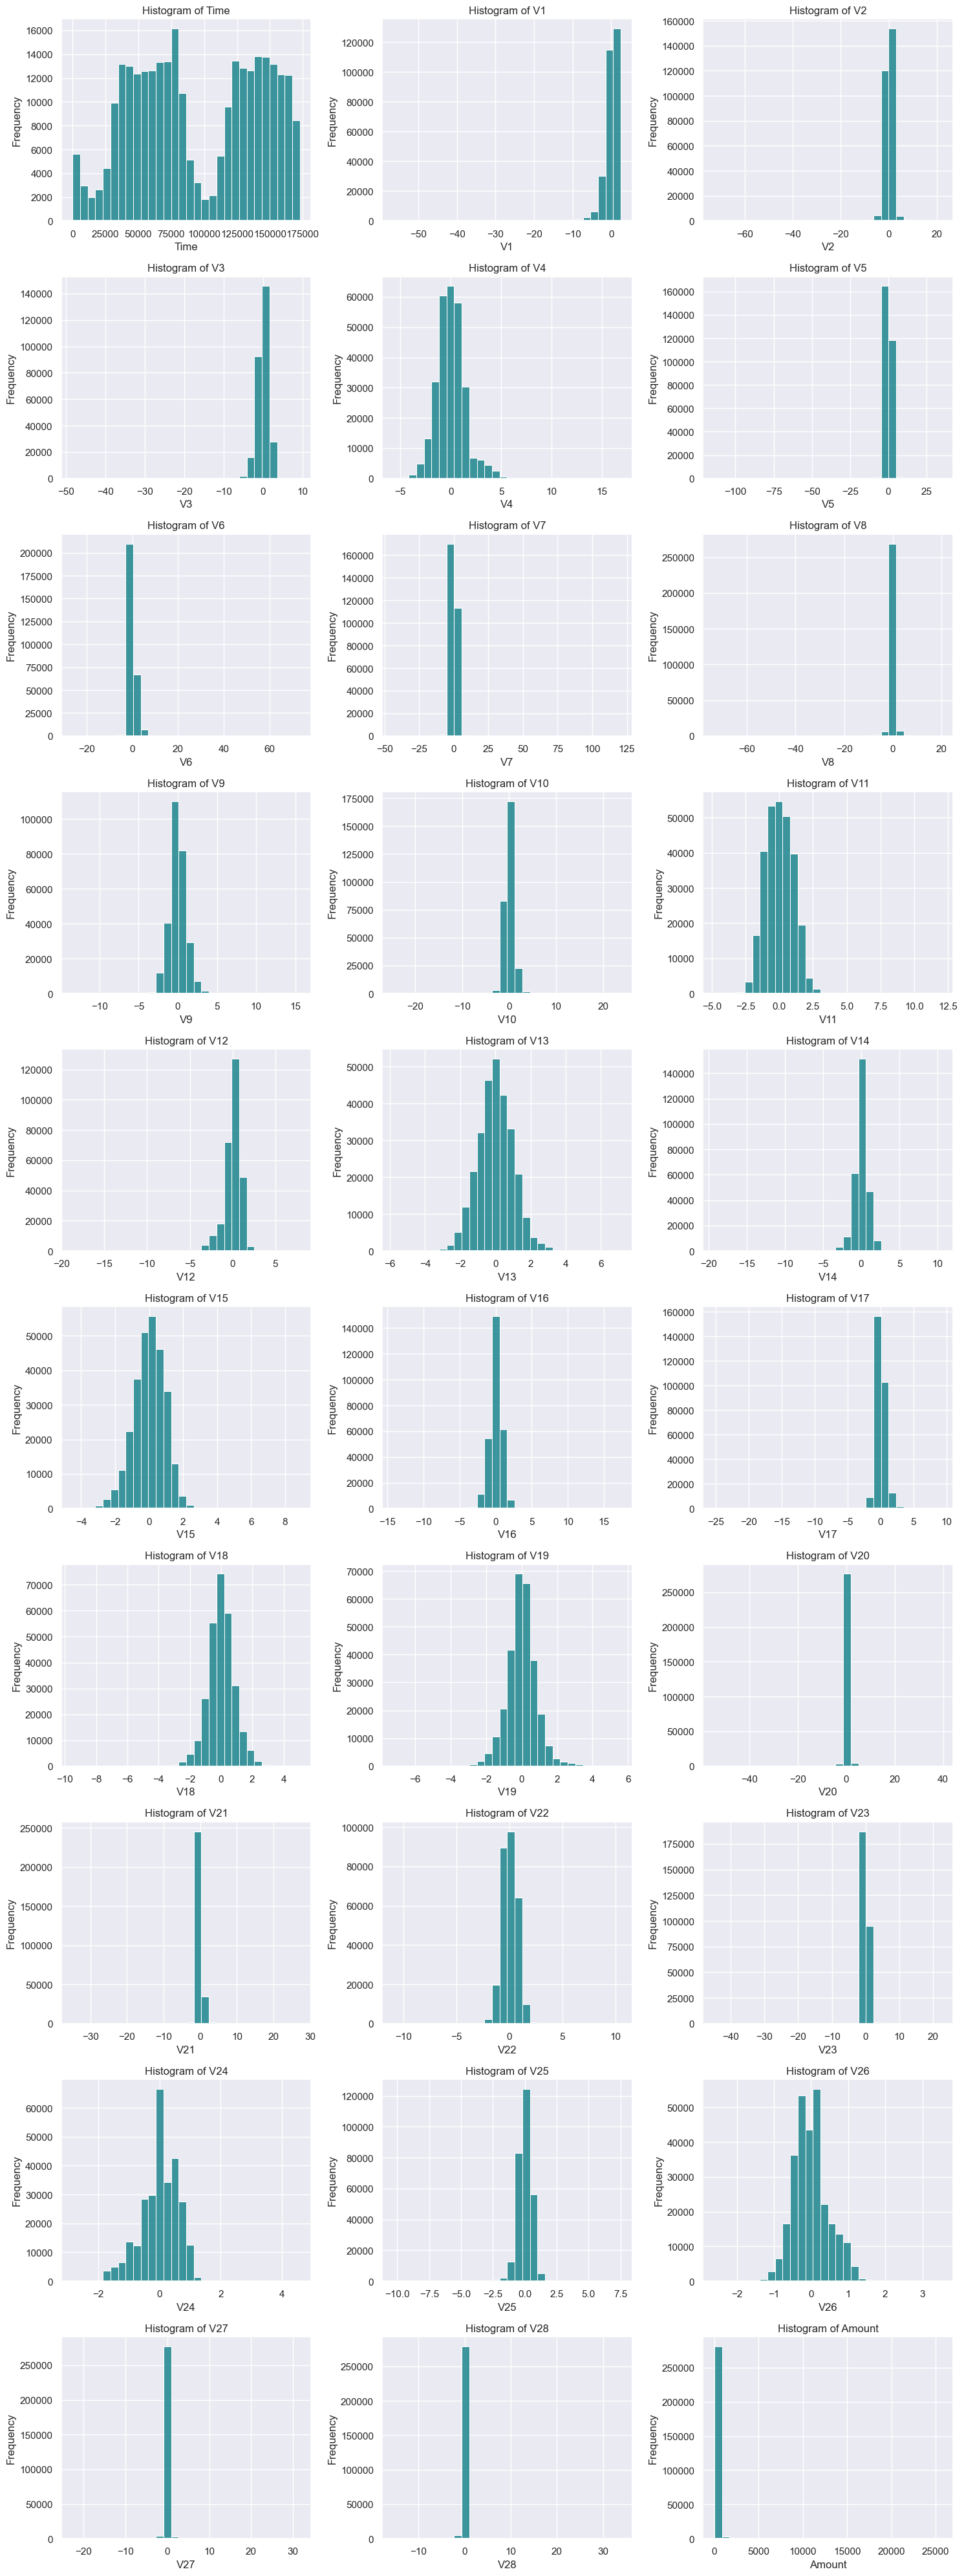

In [63]:
# Define a function to plot histograms for each feature

def plot_feature_histograms(data, features, rows=10, cols=3, figsize=(15, 40)):
    # Set up the figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Loop through features and create histograms
    for i, feature in enumerate(features):
        sns.histplot(data[feature], ax=axes[i], kde=False, bins=30)
        axes[i].set_title(f'Histogram of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    # Remove any unused subplots if the number of features is less than available subplots
    if len(features) < len(axes):
        for j in range(len(features), len(axes)):
            fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Feature names (excluding the last column as target)
features = numerical

# Call the function to plot the histograms
plot_feature_histograms(df, features, rows=10, cols=3, figsize=(15, 40))

[Table of Contents](#Table-of-Contents)

# 4. FEATURE SCALING

In [104]:
# Create a copy of the DataFrame to avoid changing the original

df_transformed = df.copy()

# Function to handle log transformation for skewed data
def log_transform_skewed(column):
    # For positive and zero values (log1p avoids log(0) errors)
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Compute skewness before transformation
skewness_before = df.skew()

# Apply transformation to skewed columns
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Compute skewness after transformation
skewness_after = df_transformed.skew()

# Compare skewness before and after
skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})

# Print the comparison
skewness_comparison

C:\Users\Tuba\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log1p

C:\Users\Tuba\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log1p



,Skewness Before,Skewness After
Time,-0.035568,-0.035568
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-0.912642
V9,0.554680,0.554680


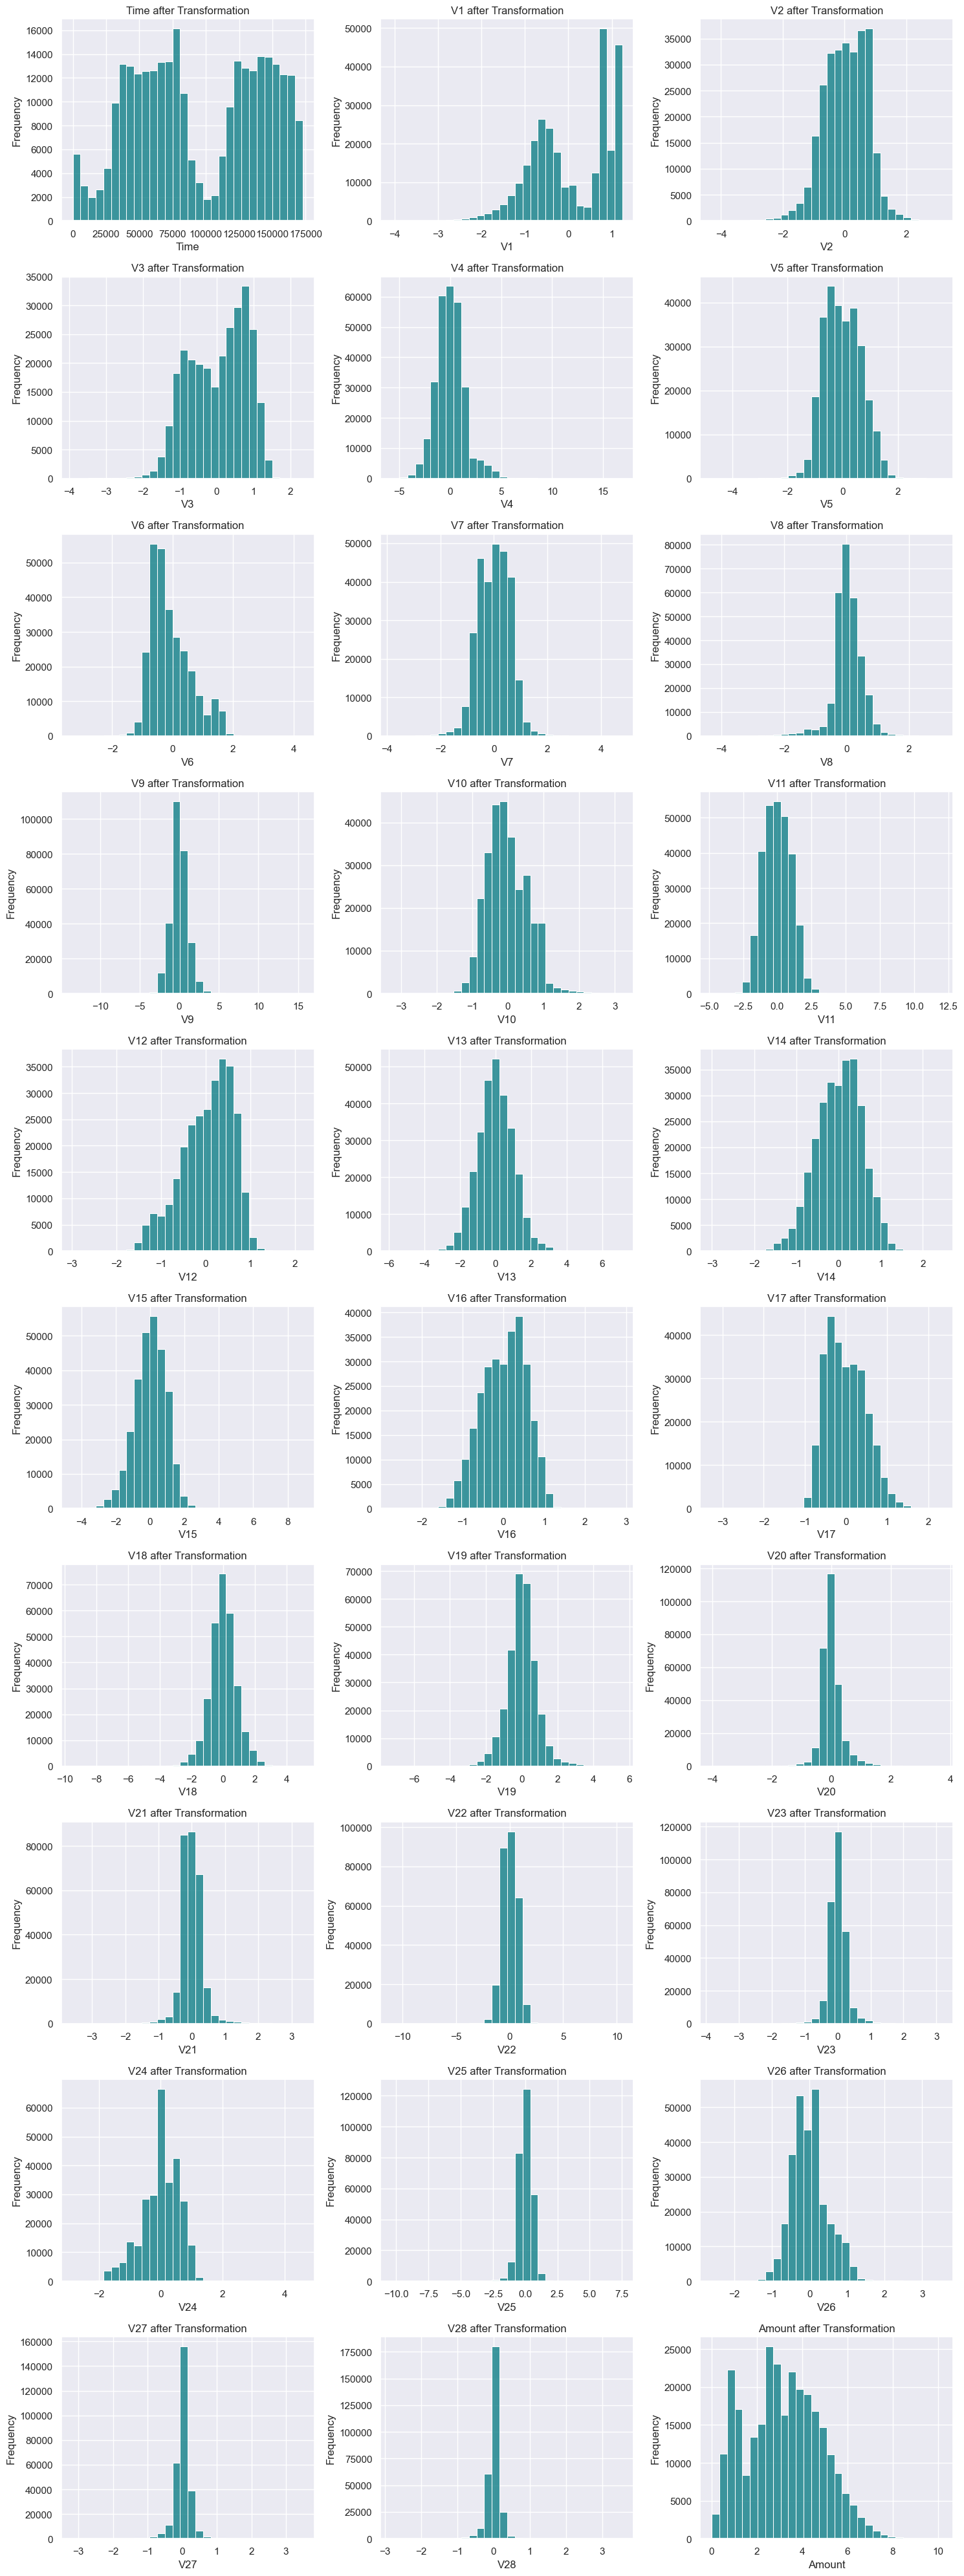

In [106]:
# Set up the figure; 10 rows (10*3=30 subplots), adjust as needed

fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

# Flatten axes array to loop through easily
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'{feature} after Transformation')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [108]:
# Separate features and target

X = df_transformed[numerical]
y = df_transformed.Class

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [110]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-0.858580,-0.070255,1.263094,1.378155,-0.291416,0.380071,0.214788,0.094126,0.363787,...,0.224273,-0.018141,0.277838,-0.104787,0.066928,0.128539,-0.189115,0.125362,-0.020835,5.014760
1,0.0,0.784749,0.235981,0.153991,0.448154,0.058286,-0.079145,-0.075852,0.081674,-0.255425,...,-0.066801,-0.203573,-0.638672,0.096480,-0.339846,0.167170,0.125895,-0.008943,0.014617,1.305626
2,1.0,-0.857964,-0.850221,1.020005,0.379780,-0.407595,1.029798,0.583031,0.221282,-1.514654,...,0.421981,0.221541,0.771679,0.646795,-0.689281,-0.327642,-0.139097,-0.053875,-0.058035,5.939276
3,1.0,-0.676139,-0.169933,1.027114,-0.863291,-0.010256,0.809686,0.213181,0.320224,-1.387024,...,-0.188997,-0.102828,0.005274,-0.174223,-1.175575,0.647376,-0.221929,0.060834,0.059643,4.824306
4,2.0,-0.769290,0.630067,0.935590,0.403034,-0.341597,0.091596,0.465582,-0.239436,0.817739,...,0.342555,-0.009387,0.798278,-0.128796,0.141267,-0.206010,0.502292,0.198377,0.194870,4.262539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-2.555763,2.404400,-2.382762,-2.066656,-1.850731,-1.282831,-1.778035,2.116898,1.914428,...,0.906575,0.193471,0.111864,0.700361,-0.509348,1.436807,0.250034,0.664568,0.600884,0.570980
284803,172787.0,-0.549732,-0.053617,1.110221,-0.738589,0.624991,0.721936,0.024038,0.258409,0.584800,...,0.057906,0.194090,0.924384,0.012386,-1.016226,-0.606624,-0.395255,0.066230,-0.052144,3.249987
284804,172788.0,1.071435,-0.263328,-1.446834,-0.557828,1.289375,1.394079,-0.259920,0.535567,0.432454,...,0.001395,0.208675,0.578229,-0.036815,0.640134,0.265745,-0.087371,0.004445,-0.026214,4.232366
284805,172788.0,-0.215466,0.425583,0.532104,0.689799,-0.320605,0.484712,-0.522466,0.518285,0.392087,...,0.119944,0.235266,0.800049,-0.151259,0.123205,-0.569159,0.546668,0.103297,0.099422,2.397895


In [112]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [114]:
X_scaled

array([[-1.99658302e+00, -1.03153646e+00, -1.41941426e-01, ...,
         5.06318192e-01, -1.28375502e-01,  1.12430334e+00],
       [-1.99658302e+00,  8.29557042e-01,  2.91860653e-01, ...,
        -5.75770042e-02,  6.54961017e-02, -1.11463897e+00],
       [-1.99656197e+00, -1.03083889e+00, -1.24681175e+00, ...,
        -2.46230201e-01, -3.31811521e-01,  1.68236843e+00],
       ...,
       [ 1.64197350e+00,  1.15423239e+00, -4.15442417e-01, ...,
        -1.36633801e-03, -1.57795386e-01,  6.52027131e-01],
       [ 1.64197350e+00, -3.03201067e-01,  5.60443197e-01, ...,
         4.13677003e-01,  5.29270219e-01, -4.55313341e-01],
       [ 1.64205773e+00, -5.43327442e-01, -2.88519738e-01, ...,
        -3.01574772e-02,  5.96981394e-02,  1.34748625e+00]])

[Table of Contents](#Table-of-Contents)

# 5. MODELLING & MODEL PERFORMANCE

## 5.1 The Implementation of Isolation Forest

**Isolation Forest:**

**Perspective:** This algorithm isolates observations by randomly selecting features and then splitting the data. Anomalies (fraudulent transactions) are more easily separated (isolated) because they tend to be rare and have different feature values from normal transactions. Each transaction is assigned an anomaly score, and those with high scores are predicted as fraud.

**Target Insight:** Fraudulent transactions are typically the ones that require fewer splits to be isolated, thus receiving higher anomaly scores.

In [118]:
# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=101)   # high contamination to catch more fraud transactions

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
iso_preds = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

# Evaluate the results
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9015054619225298


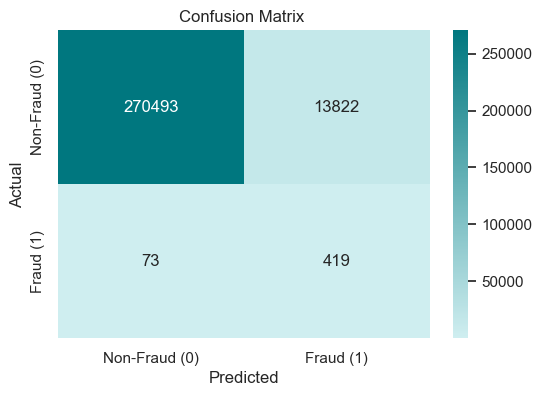

In [120]:
# Custom color palette
colors = ['#CFEEF0', '#00777F']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plot the confusion matrix
cm = confusion_matrix(y, iso_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

## 5.2 The Implementation of One-Class SVM

**One-Class SVM:**

**Perspective:** One-Class SVM models the majority class (normal transactions) by creating a decision boundary around it in a high-dimensional space. Points that fall outside this boundary are considered anomalies (fraudulent).

**Target Insight:** Transactions far from the decision boundary are labeled as fraud, while those within the boundary are labeled as normal.

In [123]:
# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
svm_preds = oc_svm.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
svm_preds = [1 if x == -1 else 0 for x in svm_preds]

# Evaluate the results
print(classification_report(y, svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9035432580861518
Confusion Matrix:


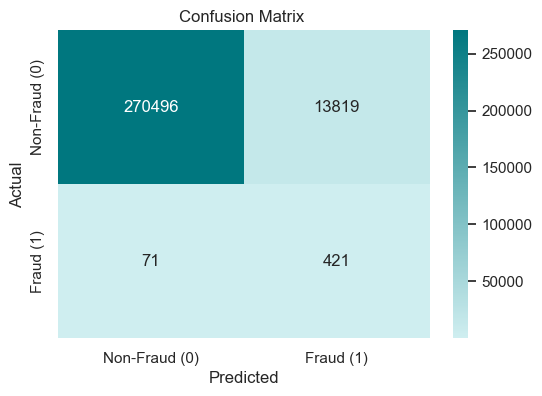

In [125]:
# Plot the confusion matrix
cm = confusion_matrix(y, svm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

## 5.3 The Implementation of Autoencoders

**Autoencoders:**

**Perspective:** Autoencoders learn to compress (encode) and then reconstruct (decode) data. They minimize the reconstruction error for normal data. Fraudulent transactions, being different from the majority, have higher reconstruction errors.

**Target Insight:** Transactions with high reconstruction errors are flagged as anomalies (fraud), as the model struggles to accurately rebuild data that deviates from the normal pattern.

In [128]:
# Define the autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    encoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    
    # Latent space
    latent = Dense(4, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(latent)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    decoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Build and compile the model
autoencoder = build_autoencoder(X_scaled.shape[1])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Train the model on normal transactions (non-fraudulent class, y == 0)
X_train = X_scaled[y == 0]
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# Calculate reconstruction error for all transactions
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)  # Adjust threshold (90th percentile)
autoen_preds = np.where(mse > threshold, 1, 0)  # 1: anomaly (fraud), 0: normal

# Evaluate the model
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)

Epoch 1/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 1.0130 - val_loss: 0.8871
Epoch 2/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 953us/step - loss: 0.8759 - val_loss: 0.8187
Epoch 3/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8397 - val_loss: 0.7892
Epoch 4/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 936us/step - loss: 0.8270 - val_loss: 0.7745
Epoch 5/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8109 - val_loss: 0.7636
Epoch 6/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8021 - val_loss: 0.7531
Epoch 7/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7921 - val_loss: 0.7468
Epoch 8/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7856 - val_loss: 0.7386
Epoch 9/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 995us/step - loss: 0.7759 - val_loss: 0.7376
Epoch 10/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.7725 - val_loss: 0.7327
Epoch 11/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7696 - val_loss: 0.7252
Epoch 12/50
7997/7997 ━

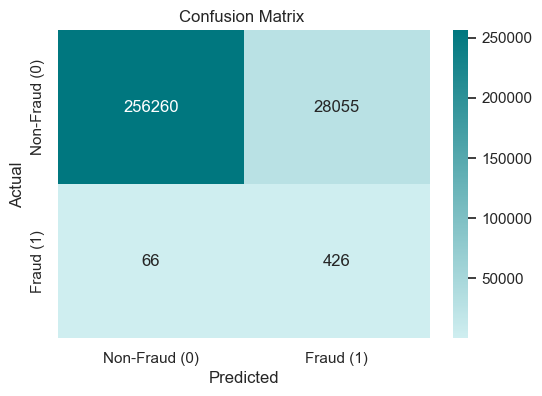

In [130]:
# Plot the confusion matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

## 5.4 The Implementation of Local Outlier Factor (LOF)

**Local Outlier Factor (LOF):**

**Perspective:** LOF measures the local density of data points compared to their neighbors. Anomalies (fraudulent transactions) are expected to have a much lower density than normal transactions.

**Target Insight:** Transactions that are located in sparse regions (with few close neighbors or much farther from their neighbors) are flagged as fraud.

In [133]:
# Initialize Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)

# Predict (returns -1 for anomalies and 1 for normal data)
lof_preds = lof.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
lof_preds = [1 if x == -1 else 0 for x in lof_preds]

# Evaluate the results
print(classification_report(y, lof_preds))
roc_auc = roc_auc_score(y, lof_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.00      0.11      0.01       492

    accuracy                           0.95    284807
   macro avg       0.50      0.53      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.5319646464494823
Confusion Matrix:
[[270130  14185]
 [   436     56]]


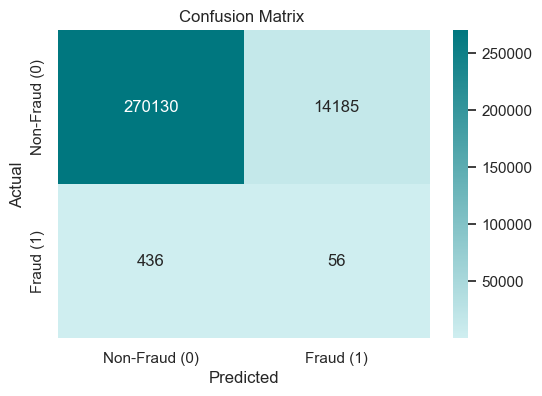

In [135]:
# Plot the confusion matrix
cm = confusion_matrix(y, lof_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

## 5.5 The Implementation of DBSCAN

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**

**Perspective:** DBSCAN clusters data based on density. Transactions that do not belong to any cluster and are considered noise points are likely to be anomalies (fraud).

**Target Insight:** Fraudulent transactions appear as noise or outliers, meaning they don’t fit well into any cluster of normal transactions.

In [138]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict (labels different clusters, outliers labeled as -1)
dbscan_preds = dbscan.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and others to 0 (non-fraud)
dbscan_preds = [1 if x == -1 else 0 for x in dbscan_preds]

# Evaluate the results
print(classification_report(y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, dbscan_preds))

              precision    recall  f1-score   support

           0       1.00      0.17      0.28    284315
           1       0.00      0.97      0.00       492

    accuracy                           0.17    284807
   macro avg       0.50      0.57      0.14    284807
weighted avg       1.00      0.17      0.28    284807

ROC AUC Score:  0.568390228746914
Confusion Matrix:
[[ 46979 237336]
 [    14    478]]


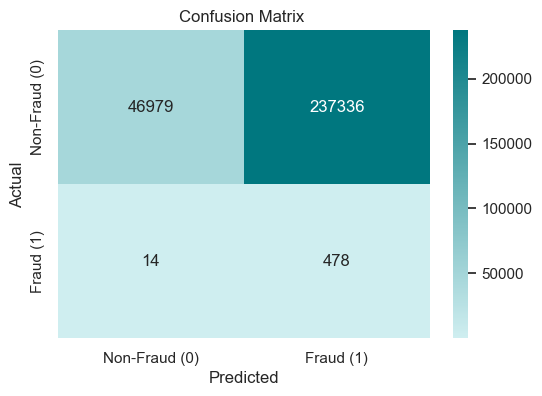

In [140]:
# Plot the confusion matrix
cm = confusion_matrix(y, dbscan_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# 6. THE COMPARISON OF MODELS

| Algorithms_Results  | Precision  | Recall    | F1-score   | ROC AUC Score   ||---------------------|------------|-----------|------------|-----------------|
|Isolation Forest	  |  3.00%	   |  85.00%   |  6.00%	    | 90.151%         |
|---------------------|------------|-----------|------------|-----------------|
|One-Class SVM	      |  3.00%	   |  86.00%   |  6.00%	    | 90.354%         |
|---------------------|------------|-----------|------------|-----------------|
|Autoencoders	      |  1.00%	   |  87.00%   |  3.00%	    | 88.359%         |
|---------------------|------------|-----------|------------|-----------------|
|Local Outlier(LOF)	  |  0.00%	   |  11.00%   |  1.00%	    | 53.196%         |
|---------------------|------------|-----------|------------|-----------------|
|DBSCAN	              |  0.00%	   |  97.00%   |  0.00%	    | 56.839%         |   |

**1. Isolation Forest**

*Precision:* 3.00% (very low) — Among the transactions detected as fraud, only 3% are actually fraudulent, suggesting many false positives.

*Recall:* 85.00% (high) — The model successfully identifies 85% of the fraudulent transactions, meaning it’s good at catching fraud but at the cost of precision.

*F1-Score:* 6.00% (low) — The low F1 score shows the imbalance between Precision and Recall.

*ROC AUC Score:* 90.151% — This high score indicates good discrimination between fraud and non-fraud, even though Precision is low.

**2. One-Class SVM**

*Precision:* 3.00% (very low) — Like Isolation Forest, Precision is low, suggesting many false positives.

*Recall:* 86.00% (high) — Slightly higher than Isolation Forest, it captures a significant portion of fraudulent transactions.

*F1-Score:* 6.00% (low) — Similar to Isolation Forest, indicating a low balance between Precision and Recall.

*ROC AUC Score:* 90.354% — This score is slightly higher than Isolation Forest, indicating that it can separate fraud and non-fraud relatively well.

**3. Autoencoders**

*Precision:* 1.00% (very low) — Very few of the predicted fraud cases are actual fraud.

*Recall:* 87.00% (high) — High recall shows that Autoencoders identify most of the fraudulent transactions.

*F1-Score:* 3.00% (very low) — The low F1 score again indicates poor balance.

*ROC AUC Score:* 88.359% — The score is lower than Isolation Forest and One-Class SVM but still reasonable.

**4. Local Outlier Factor (LOF)**

*Precision:* 0.00% — The model fails to achieve any true positives, indicating it may not be effective for this dataset.

*Recall:* 11.00% — Very low recall means it misses most fraudulent transactions.

*F1-Score:* 1.00% — The lowest F1 score, showing poor performance overall.

*ROC AUC Score:* 53.196% — The low ROC AUC score confirms that LOF does not effectively distinguish between fraud and non-fraud transactions in this case.

**5. DBSCAN**

*Precision:* 0.00% — Like LOF, DBSCAN has no true positives, indicating no effective fraud detection.

*Recall:* 97.00% — Very high recall, suggesting it identifies nearly all fraud but likely with high false positives.

*F1-Score:* 0.00% — Due to the zero precision, the F1 score is 0.

*ROC AUC Score:* 56.839% — While better than LOF, the ROC AUC is still low, indicating poor performance for fraud detection.

**Summary**
* *Isolation Forest* and *One-Class SVM* appear to be the best algorithms here, with high Recall and reasonable ROC AUC scores. However, both have low Precision, meaning they tend to mislabel normal transactions as fraud.
* *Autoencoders* perform moderately well in terms of Recall but fall short in Precision.
* *Local Outlier Factor* and *DBSCAN* perform poorly on this dataset, as evidenced by their low Precision, F1-scores, and ROC AUC values, indicating they are not suitable for this particular problem.

# 7. CONCLUSION

* For this fraud detection problem, **Isolation Forest** and **One-Class SVM** emerged as the best-performing algorithms among the five evaluated. Both methods demonstrate high Recall (85% and 86%, respectively) and ROC AUC scores (over 90%), indicating strong ability to detect fraud cases and reasonably distinguish between fraudulent and non-fraudulent transactions. However, their low Precision values (3%) reveal a significant number of false positives — normal transactions labeled as fraud — which could result in a high number of unnecessary alerts or investigations.

* **Autoencoders** also show high Recall (87%) but even lower Precision (1%), making them less reliable due to more frequent false positives. While Autoencoders demonstrate fair discrimination capability (ROC AUC of 88%), the imbalance between Precision and Recall reduces their practical value in this case.

* **Local Outlier Factor (LOF)** and **DBSCAN** underperform, with low Precision, Recall, F1 scores, and ROC AUC values. These algorithms struggle to effectively distinguish fraud in this dataset, as evidenced by their near-zero Precision and F1-scores. They may not be suitable for this problem, given their high error rates in identifying fraudulent transactions.

# Note

* Given the high Recall and ROC AUC of Isolation Forest and One-Class SVM, these algorithms are currently the most viable options for this fraud detection problem. However, to reduce false positives and improve Precision, further tuning or exploring hybrid approaches (such as combining anomaly detection with supervised learning for refinement) may be beneficial. Additionally, implementing a threshold or post-processing step to manage the trade-off between Precision and Recall could help make these models more practical for real-world use.

# 8. REFERENCES
* https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
* https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud/notebook
* https://www.kaggle.com/code/kachalisarma20/credit-card-anomaly-detection#Model-Building-and-prediction
* https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets#Anomaly-Detection:
* https://www.kaggle.com/code/sugataghosh/anomaly-detection-in-credit-card-transactions#Implementing-Anomaly-Detection


[Table of Contents](#Table-of-Contents)